# Exploratory Data Analysis - covariants
by __Pawel Rosikiewicz__ 

---





## General comments
* helper funcitons were created specifically for that 
* for easier inspection, I am loding individual functions, and configurations, prepared for this projects before each section,
* all my funcitons, have help, please do not hesisate to test them, 

## materials 
general purpose
abstract and information
tools I used, 
    - data frame explorer, 
    - modified funcitons, based on my older open-source code that I prepared for that project
    - custom funcitons,
project setup, 
    - how did i organized that
    - 
    
    
    
    
__GOALS:__  To decide how:    
* data encoding, and tranformation schema for model    
* how the missing data    
* to identify and then, to potentiall remove or clip outliers   
    
__MAIN QUESTIONS:__
* what is the number of numeric, and categorical features?
* what is the range or class number in each feature?
* what is the amount and distribusion of missing data?
* are all features balanced?
* get examples of each feature

    
__TOOLS:__  
    
    
__FUTURE DEVELOPMENTS:__  
my suggestions, added at the end of this notebook, what could be done more, if more time and resourser woudl be avialable, 



 



## Setup
---

In [1]:
import os
import sys
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
# basedir
basedir = os.path.dirname(os.getcwd())
os.chdir(basedir)
sys.path.append(basedir)

In [3]:
# paths
PATH_data_raw     = os.path.join(basedir, "data/raw")
PATH_data_interim = os.path.join(basedir, "data/interim")
PATH_results      = os.path.join(basedir, "data/results")
PATH_models       = os.path.join(basedir, "models")

In [4]:
# load custom functions
from src.utils.DataFrameExplorer import DataFrameExplorer_summary as dfe # plots with pandas df summary
from src.utils.DataFrameExplorer import DataFrameExplorer_features as dfe_features # provides data examples 
from src.utils.DataFrameExplorer import DataFrameExplorer_cleaning as dfe_cleaning # used for data cleanign and formatting
from src.utils.DataFrameExplorer import DataFrameExplorer_duplicates as dfe_duplicates # used to detect column duplicates

# modificaitons of my older scripts created for this project 
from src.utils.DataFrameExplorer_modif import DataFrameExplorer_groups as dfe_groups # plots comparing two or more dataframes

## Step 1. Load the data

In [5]:
from src.utils.helper_data_loaders import load_tsv

# load target data
data_cov =  load_tsv(PATH_data_raw, 'X_covariates.tsv')
data_genes = load_tsv(PATH_data_raw, 'X_genes.tsv')
target = load_tsv(PATH_data_raw, 'y.tsv', header=None)

# small correction
target.columns=["target"]

(200, 17)
(200, 31085)
(200, 1)


## Step 2. Prepare the data for EDA - Covariants pipeline

__About the pipeline__
* __intended use:__
    * to quickly analize the dataset provided with the task
    * by separating the preparation step, you may introduce chnages such as impite missing data, or remove rows with missing dfata to run the same analysis, quickly, and compare the results, 
* __the pipeline require following inputs:__
    * dataframe with features, called here covarinats, and the target variable,
    * lists with feature assigment: ie. list with names of target, quantitative, and categorical variables, 
    * list with potential confouding factors, that may be used for error analysis, cross-validation and stratyficaiton of the results, 
* __target variable:__
    * it is assumed be the name of the target variable, but it can be changed 
    * the pipeline work with only one target variable, 



### (A) __define variables__

__list different types of variables__
* this step may also be done, automatically, with pandas funcitons, when more features are used,   
* it was done, after initial analysis
* __caution__, if feature name is not listed, it wont be used in some of the further analyses

__modifications history__
* __'Baseline ECOG Score'__ is used as categorical variable, for more see my notes:  

In [6]:
VAR_GROUPS = dict(
    TARGET_VAR = ["target"],
    CATEGORICAL_VAR = [ 'Baseline ECOG Score', 'Enrollment IC', 'IC Level', 'TC Level', 'Immune phenotype', 'Sex',
           'TCGA Subtype', 'Lund', 'Lund2', 'Received platinum',
           'Met Disease Status', 'Sample age', 'Sample collected pre-platinum',
           'Intravesical BCG administered', 'Tobacco Use History'],
    QUANTITATIVE_VAR = ['FMOne mutation burden per MB', 'Neoantigen burden per MB'],
)

__variable encoding__

In [7]:
VAR_DTYPES = {
    "TARGET_VAR": "int", # only for EDA
    "CATEGORICAL_VAR": "O",
    "QUANTITATIVE_VAR": "float64"
}

__target variable encoding__   
* its a dictionary, that provide desriptive names for classes in target variable,    
* used to impove results intepretability 
* __target variable__; response status of patients (1-responder, 0-non-responder)
* __Caution__; in some analyses, I am using numerical form of the target variable, 

In [8]:
TARGET_ENCODING = {0:"non-responder", 1:"responder"}

__List potential confounding variables__
* here are the examples, of potential variables, that may or may not affect model accuracy
* i will be using at least some of these variables, like Sex, to stratify the results, and chek how good are model preditions/erro in each strata,  
* Justificaiton for the selected features:
    * I selected __'Sex'__, and __'Tabaco Use history'__, based on my domain knowledge, and because I general overview of the data showed difference in the number of man/women, I also expected to see more smoking men, then women, that I wish to test in the next step.
    * caution: more gorups, may be added later on, 
* __OBSERVATIONS__
    * because we have very limited number of samples (200 for train & test data), I will be use each factor separately, and not in a comabintion, for analysis of the results

In [9]:
CONFOUNDING_VAR = ['Sex', 'Tobacco Use History']

### __(B) prepare the data__
* several steps, were added based onmy initial analysis 
* these new, soptional steps, are in the second cell, each with justificaiton,

In [10]:
# input data
data_df = data_cov.copy()
target = target.copy()

# rename target variable to default name, 
target.columns=["target"]

# add target variable to data for eda
data_df = pd.concat([data_cov, target], axis=1)
print(data_df.shape)

(200, 18)


In [11]:
# Encoding - dtype
'''test for proper encoding is done in Steps 3a and b, '''
for fgroup, fdtype in VAR_DTYPES.items():
    for fname in VAR_GROUPS[fgroup]:
        data_df.loc[:,fname] = data_df.loc[:,fname].astype(fdtype)
        try:
            data_df.loc[:,fname] = data_df.loc[:,fname].astype(fdtype)
        except:
            print(f'KeyError: for {fgroup}, {fdtype},{fname}')  

# because it is classyficaiton problem, replace values in target variable for EDA
data_df_eda = data_df.copy()
data_df_eda.loc[:,"target"].replace(TARGET_ENCODING, inplace=True)

## Step 3 Dataset overview
---

### __(A) Dataset overview__

* first look on all variables, amount of missing data, examples from each feature, class number, and range of numerical variables,
* check if data preparaiton provided results like expected: eg. 
    * do you have some missing data in target variable, or unknownw classes, 
    * have you removed all rows/columns with missing data - if applied
    * have you replaced all missing data wiht your imputaiton strategy - if applied
* I am using scripts that I developed in 2019/2020 for fast exploration of python data frames, collected into dataFrame Explorer a future package, currently under development
* all skipts are available under MIT license
* all functions were provided with help description, 

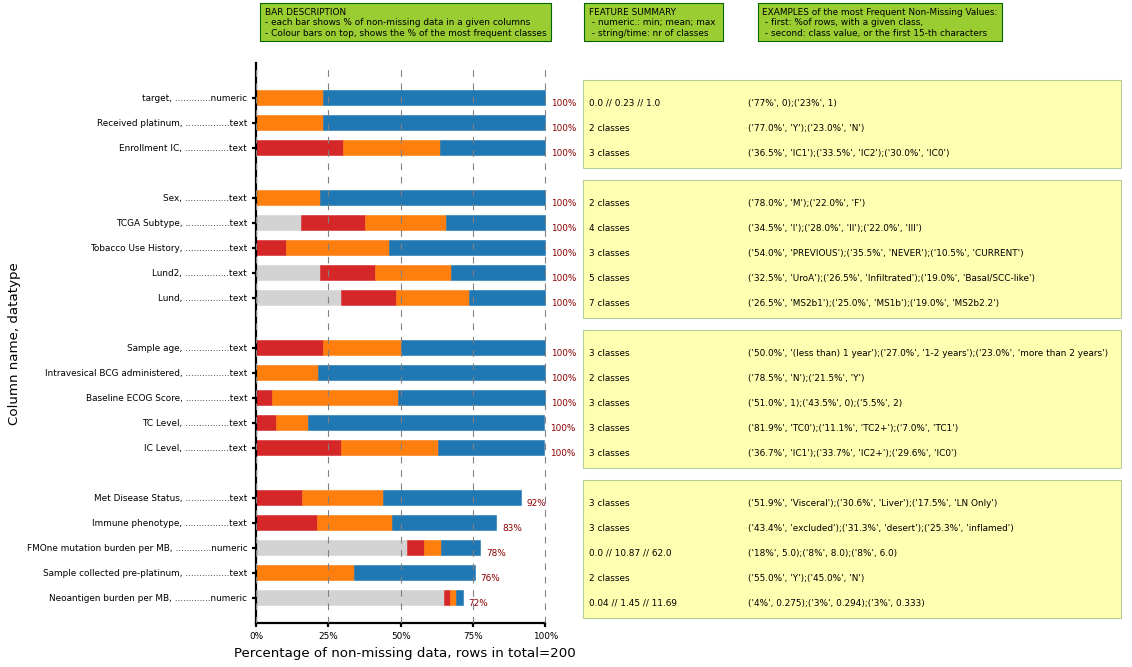

In [12]:
# check for missing data , and examples in each variable
'TIP: Double click on the image to enlarge'
dfe.df_summary_plot(df=data_df, pieChart=False, showTable=False, barPlot=True, barPlot_figsize=(14,10)) 

## __(B) Check variable encoding, and get value examples from each feature__
---

__check if all features were assigned correctly, and without duplicates__   

In [13]:
examples, _, _ = dfe_features.show_unlisted_variables(data_df, VAR_GROUPS, verbose=True, n=2)

input df var: 18
provided var names: 18
-----------------------------------
defined var: 18 - (these variable names were found in df) 
undefined var: 0 - (these variable names are in df, and were not specified in input list)
unknownw var: 0 - (these variable names were provided in input list, but were missing in df.columns)



__get examples from each feature, and chek if they were correctly assigned__
* eg1. g2, etc... - egample one, two and three...., values and counts
* percentage of examples in each feature, is in brackets, 
* None, returned, if there are less classes, then requested number of examples (n, in dfe_features.show_unlisted_variables)

In [14]:
display(examples)

name    dtype  class_nr  instances  na  \
0                          target    int64         2        200   0   
1             Baseline ECOG Score   object         3        200   0   
2                   Enrollment IC   object         3        200   0   
3                        IC Level   object         3        200   1   
4                        TC Level   object         3        200   1   
5                Immune phenotype   object         3        200  34   
6                             Sex   object         2        200   0   
7                    TCGA Subtype   object         4        200   0   
8                            Lund   object         7        200   0   
9                           Lund2   object         5        200   0   
10              Received platinum   object         2        200   0   
11             Met Disease Status   object         3        200  17   
12                     Sample age   object         3        200   0   
13  Sample collected pre-platinum   object         2        200  49   
14  Intravesical BCG administered   object         2        200   0   
15            Tobacco Use History   object         3        200   0   
16   FMOne mutation burden per MB  float64        30        200  45   
17       Neoantigen burden per MB  float64        94        200  57   

             eg1_value    eg1_counts    eg2_value   eg2_counts  
0                    0  154; (77.0%)            1  46; (23.0%)  
1                    1  102; (51.0%)            0  87; (43.5%)  
2                  IC1   73; (36.5%)          IC2  67; (33.5%)  
3                  IC1   73; (36.5%)         IC2+  67; (33.5%)  
4                  TC0  163; (81.5%)         TC2+  22; (11.0%)  
5             excluded   72; (36.0%)       desert  52; (26.0%)  
6                    M  156; (78.0%)            F  44; (22.0%)  
7                    I   69; (34.5%)           II  56; (28.0%)  
8                MS2b1   53; (26.5%)         MS1b  50; (25.0%)  
9                 UroA   65; (32.5%)  Infiltrated  53; (26.5%)  
10                   Y  154; (77.0%)            N  46; (23.0%)  
11            Visceral   95; (47.5%)        Liver  56; (28.0%)  
12  (less than) 1 year  100; (50.0%)    1-2 years  54; (27.0%)  
13                   Y   83; (41.5%)            N  68; (34.0%)  
14                   N  157; (78.5%)            Y  43; (21.5%)  
15            PREVIOUS  108; (54.0%)        NEVER  71; (35.5%)  
16                 5.0   27; (13.5%)          8.0   12; (6.0%)  
17             0.27451     5; (2.5%)     0.843137    4; (2.0%)

### __stratify the data with target variable and potential confounding variables__
---

__GOAL:__   
__OBSERVATIONS:__

__load my function prepared for that task__   
it creates confusion matrix, with number of examples and % in each row/total from any number of features

In [15]:
from src.utils.helper_get_summary import get_feature_summary 

In [16]:
# features to display, the last one, will be used as column names,
features = VAR_GROUPS["TARGET_VAR"].copy()
features.extend(CONFOUNDING_VAR)

__show examples of each dtype, from each feature__

In [17]:
# you may also see more examples using show_df_examples
dfe_features.show_df_exaples(data_df, features, n=3)

name   dtype  class_nr  instances  na eg1_value  \
0               target   int64         2        200   0         0   
1                  Sex  object         2        200   0         M   
2  Tobacco Use History  object         3        200   0  PREVIOUS   

     eg1_counts eg2_value   eg2_counts eg3_value   eg3_counts  
0  154; (77.0%)         1  46; (23.0%)      None         None  
1  156; (78.0%)         F  44; (22.0%)      None         None  
2  108; (54.0%)     NEVER  71; (35.5%)   CURRENT  21; (10.5%)

In [18]:
# create summary table
df_res, _ = get_feature_summary(data_df, features, fillna="not_recorded")  
display(df_res)

CURRENT       NEVER    PREVIOUS  - sum & (% of total)
target Sex                                                          
0      F      3   (8%)  19   (52%)  14   (38%)  -           36 (18%)
       M    15   (12%)  39   (33%)  64   (54%)  -          118 (59%)
1      F     1   (12%)   3   (37%)   4   (50%)  -             8 (4%)
       M      2   (5%)  10   (26%)  26   (68%)  -           38 (19%)

__check the effect of the target variable and confounding factors on class/value composition in other features__

............................................................
- 1 - target
............................................................


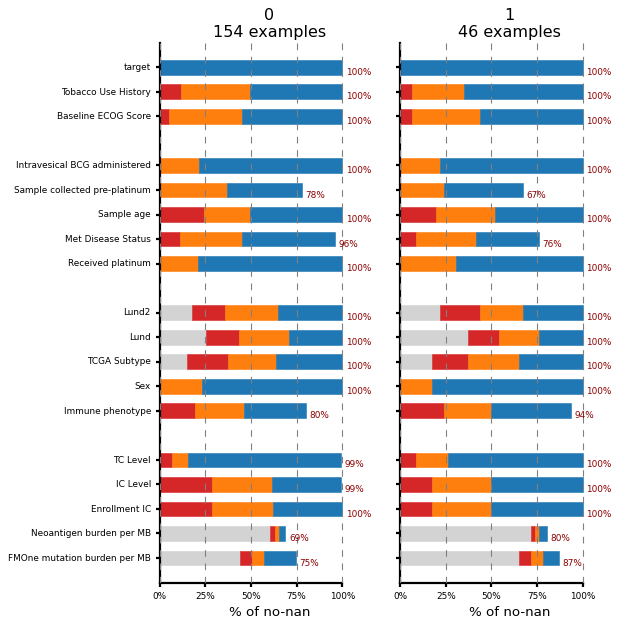

............................................................
- 2 - Sex
............................................................


F            M  - sum & (% of total)
target                                               
0       36   (23%)  118   (76%)  -          154 (77%)
1        8   (17%)   38   (82%)  -           46 (23%)

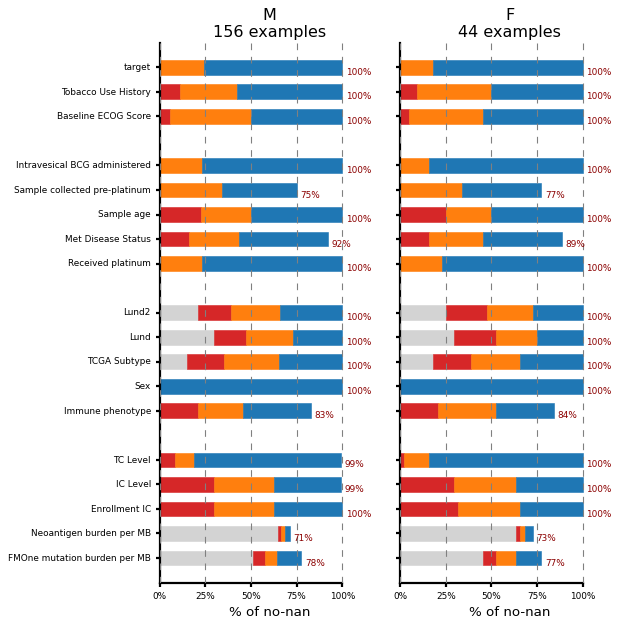

............................................................
- 3 - Tobacco Use History
............................................................


CURRENT       NEVER    PREVIOUS  - sum & (% of total)
target                                                          
0       18   (11%)  58   (37%)  78   (50%)  -          154 (77%)
1         3   (6%)  13   (28%)  30   (65%)  -           46 (23%)

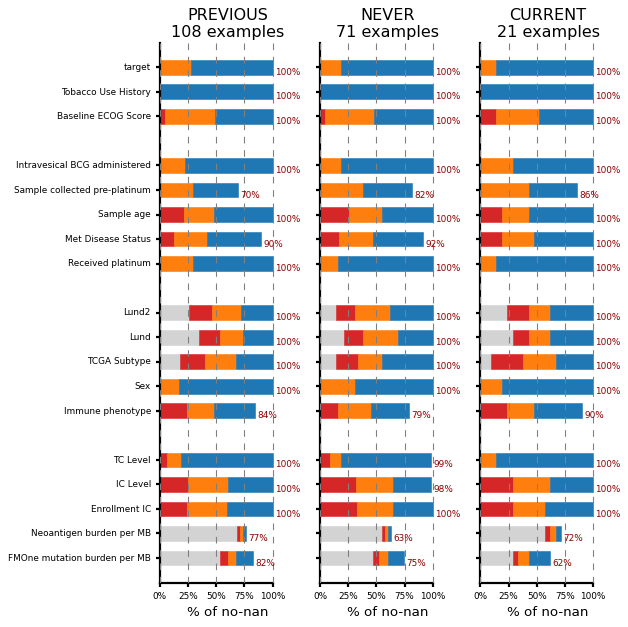

In [19]:
# check each of potential confounding factors, 
for i, conf_var in enumerate(features):
    print(f'{"".join(["."]*60)}\n- {i+1} - {conf_var}\n{"".join(["."]*60)}')
    
    # display confusion matrix, with number of examples and % in each row/total
    if VAR_GROUPS["TARGET_VAR"][0]!=conf_var:
        features = [VAR_GROUPS["TARGET_VAR"][0],  conf_var]
        df_res, _ = get_feature_summary(data_df, features, fillna="not_collected")  
        display(df_res)
    else:
        pass

    # check for missing data , and examples in each variable
    dfe_groups.compare_groups_with_df_summary_plot(
        df=data_df,
        fname=conf_var,
        fig_size=(8,8)
    )

## __Explore Quantitative variables__
---

__GOAL:__   
__OBSERVATIONS:__

__Key-points__
* Normality check for sample distribusion: 
    * visual and quantitative test of normality for each numerical attribute, 
* finding extreme samples - outliers

__Outliers definition__
* typically, we may define certain points as potential outliers, if more than 1.5*IQR (inter- quartile range), or more than two standard deviations, from the sample mean.
* Causes:
    * mistakes, >>> best to exlude, 
    * rare or extreme values >>> shodul be used 
    
    
#### we can now test normality with statistical tests & descriptive statistics in each variable
* data distribusion of all quantitative variables signifficantly different from normal distribusion!
* therefore, these variables should also be transformed.
    * Some independent variables look like good candidates for log transformation: TotalBsmtSF, KitchenAbvGr, LotFrontage, LotArea and others. While ganining on regression transformation will smooth out some irregularities which could be important like large amount of houses with 0 2ndFlrSF. Such irregularities are good candidates for feature construction.
    
    
    ----
    ---
    ---

__import my fucntions__ (all functions have help provided)

In [20]:
from src.utils.helper_full_test_for_normality import test_normality
from src.utils.DataFrameExplorer.DataFrameExplorer_distribusion import normality_plots
from src.utils.DataFrameExplorer.DataFrameExplorer_distribusion import check_normality
from src.utils.DataFrameExplorer.DataFrameExplorer_distribusion import feature_distribution

# for depracietad function names, 
'''reson: I wrote these functions over a year ago, and they are still working but I woudl need to update them'''
warnings.filterwarnings("ignore") 

__and traduitionally, provide examples of the most frequent values from each feature, to help the user with the analysis__


............................................................
- check normality wiht popular statistical tests
............................................................


attribute    dtype  data points  na count  skewness  \
0  FMOne mutation burden per MB  float64          200        45    2.6679   
1      Neoantigen burden per MB  float64          200        57    3.0337   

   kurtosis    mean      sd    normaltest  Shapiro-Wilk  Kolmogorov-Smirnov  
0   10.1064  10.871  9.2943  9.121941e-25  7.714657e-15            0.000499  
1   12.0557   1.451  1.7365  4.080901e-26  2.284511e-16            0.000001


............................................................
-  check normality wiht plots and descriptive stats.
............................................................


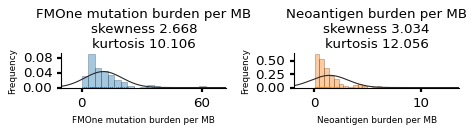

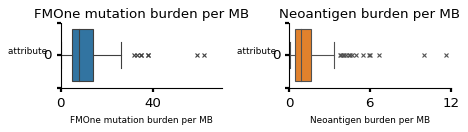

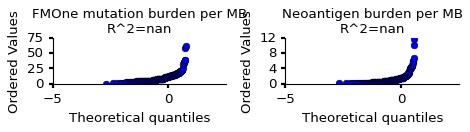


............................................................
- feature examples
............................................................
Error: please, check dtype of the selected variables, or feature names provided


In [21]:
test_normality(data_df, VAR_GROUPS["QUANTITATIVE_VAR"])

__test potential feature transformations__
* impute missing data
* scaling
* log2p 

__(a) create data preprocessor for numeric features__

In [22]:
from sklearn import set_config
from sklearn.preprocessing import FunctionTransformer # creates custom transfomers
from sklearn.pipeline import make_pipeline, Pipeline # like pipeline function, but give step names automatically, 
from sklearn.compose import ColumnTransformer # allows using different transformers to different columns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer # skleanr transformers,

# Comment
'I placed everythign in one cell so it can be easilty copied'

# input data
df = data_df.copy()

# inputs
numeric_features = VAR_GROUPS["QUANTITATIVE_VAR"].copy()

# find all other features in input data
all_other_features = df.columns.values.tolist()
for v in numeric_features:
    try:
        all_other_features.remove(v)
    except:
        pass
    
# create custom transformer
log_scale_transformer = make_pipeline( 
    FunctionTransformer(np.abs, validate=False),   
    FunctionTransformer(np.log1p, validate=False), # creates runtime warning if negative data are used
    StandardScaler()
)

# create data preprocessor for numeric features
numeric_transformer = Pipeline(steps=[
        ("imputer",SimpleImputer(strategy='mean')), 
        ("scaler",StandardScaler())
    ])

# preprocessor for all the data
''' ColumnTransformer: it allows apllying different tranfomers to different columns
    - give unique names for each transformer
    - passthrough - keyword, nothing is done with that column
    - column names are always provided as LIST
'''
preprocessor = make_pipeline(
    ColumnTransformer(
        transformers = [
            ("numeric_features", numeric_transformer, numeric_features),
            ("other_features", "drop", all_other_features), # "passthrough" other option, 
        ])
    )

# check if everythign is ok
set_config(display="diagram") # or "text"
preprocessor

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['FMOne mutation burden per '
                                                   'MB',
                                                   'Neoantigen burden per MB']),
                                                 ('other_features', 'drop',
                                                  ['Enrollment IC', 'IC Level',
                                                   'TC Level',
                                                   'Immune phenotype', 'Sex',
                                                   'TCGA Subtype', 'Lund',
                                                   'Lund2', 'Received platinum',
                                                   'Met Disease Status',
                                                   'Sample age',
                                                   'Sample collected '
                                                   'pre-platinum',
                                                   'Intravesical BCG '
                                                   'administered',
                                                   'Baseline ECOG Score',
                                                   'Tobacco Use History',
                                                   'target'])]))])


............................................................
- check normality wiht popular statistical tests
............................................................


attribute    dtype  data points  na count  skewness  \
0  FMOne mutation burden per MB  float64          200         0    3.0239   
1      Neoantigen burden per MB  float64          200         0    3.5769   

   kurtosis  mean   sd    normaltest  Shapiro-Wilk  Kolmogorov-Smirnov  
0   13.8178  -0.0  1.0  6.378297e-35  1.369560e-17        6.995986e-09  
1   17.8888   0.0  1.0  2.603211e-40  4.252903e-20        6.403182e-16


............................................................
-  check normality wiht plots and descriptive stats.
............................................................


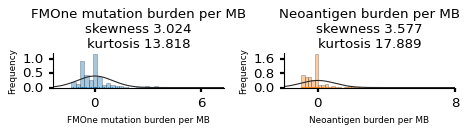

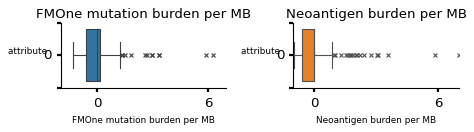

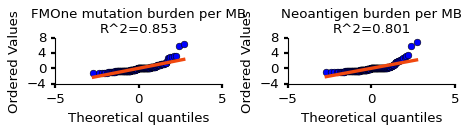


............................................................
- feature examples
............................................................
Error: please, check dtype of the selected variables, or feature names provided


In [23]:
# transform the data 
prepared_data = preprocessor.fit_transform(data_df)
prepared_data = pd.DataFrame(prepared_data, columns=VAR_GROUPS["QUANTITATIVE_VAR"])

# repeat test for normality
test_normality(prepared_data, VAR_GROUPS["QUANTITATIVE_VAR"])

### __check if numerical variables have different values in different classes__

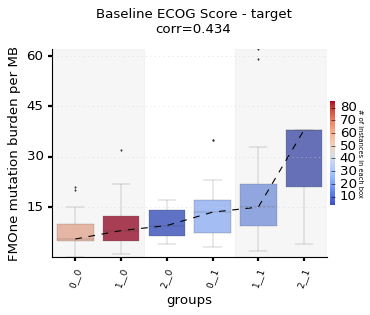

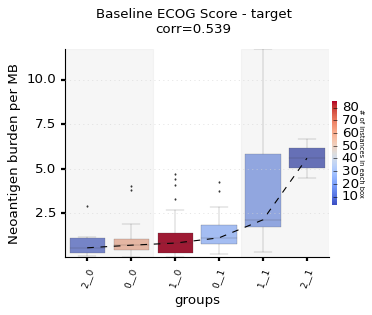

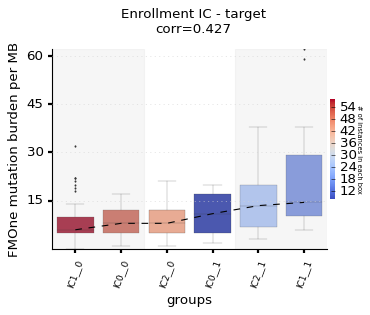

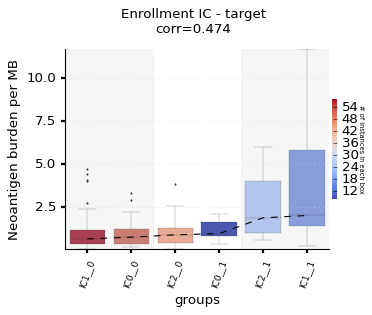

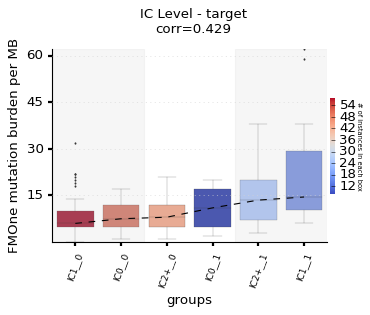

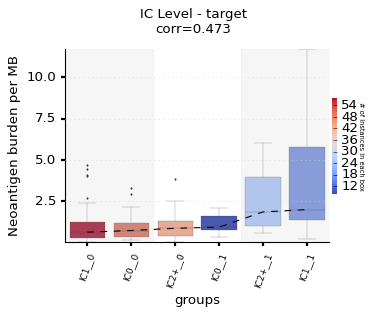

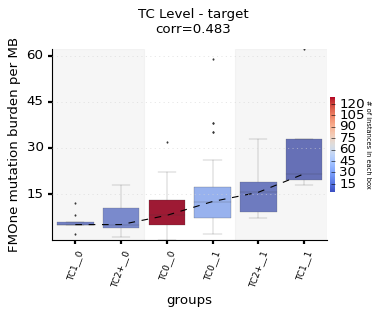

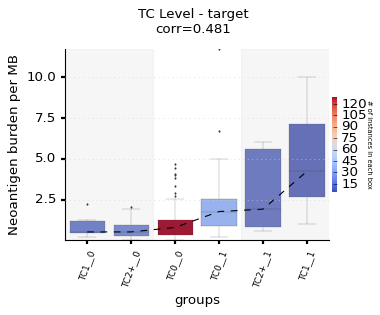

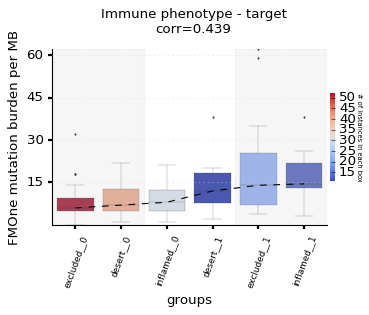

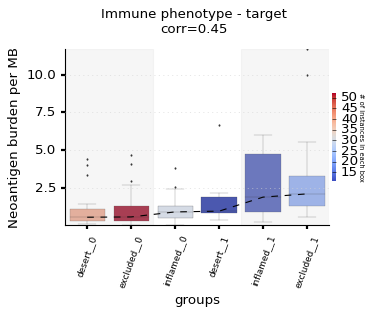

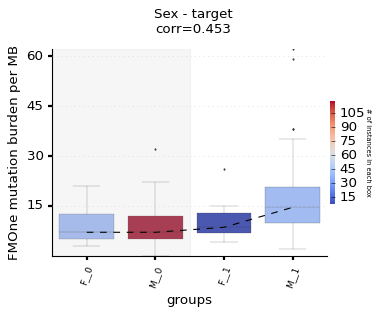

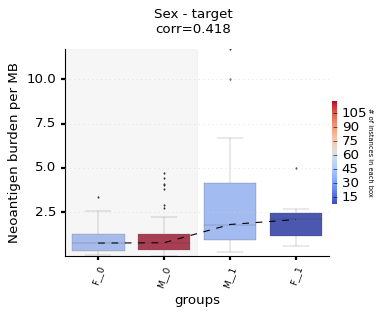

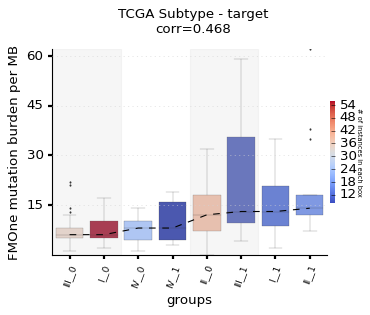

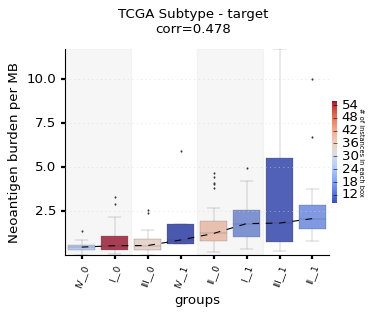

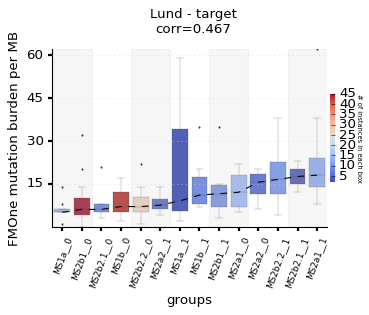

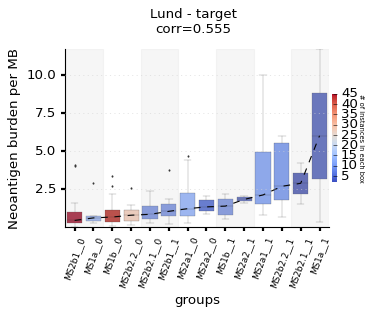

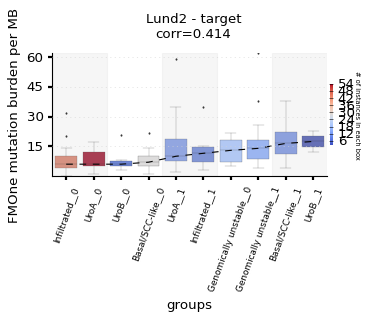

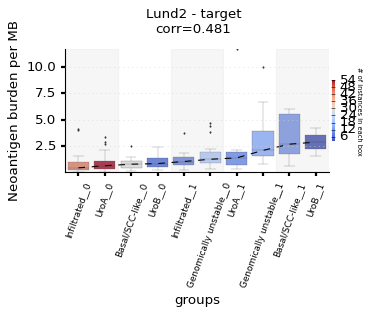

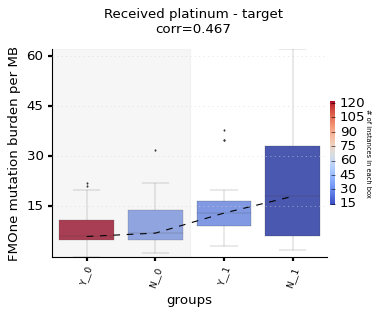

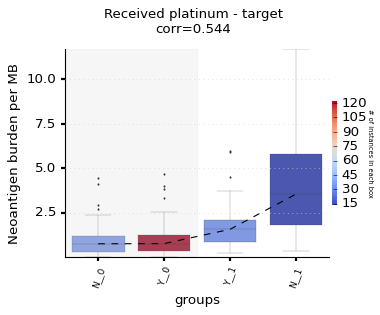

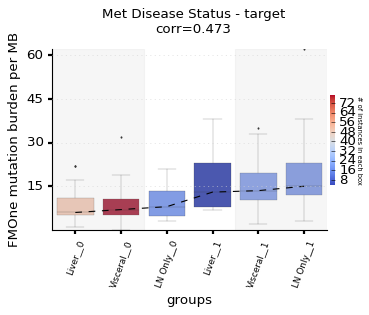

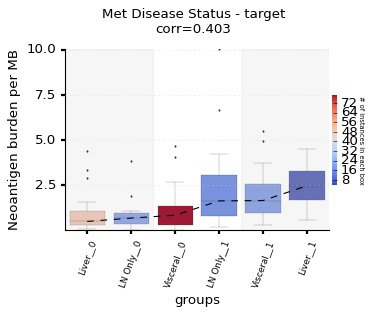

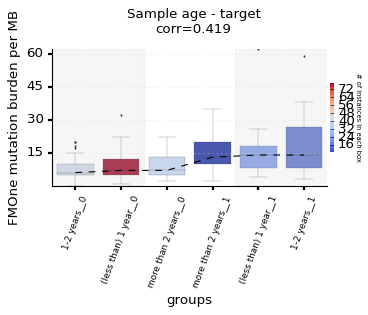

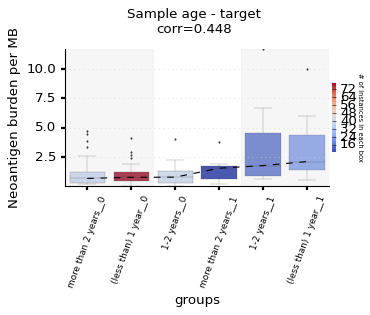

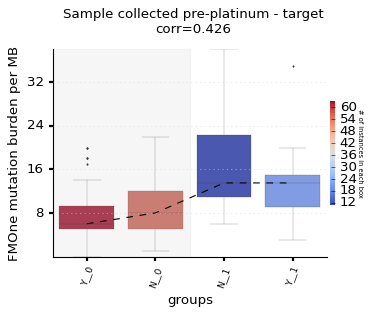

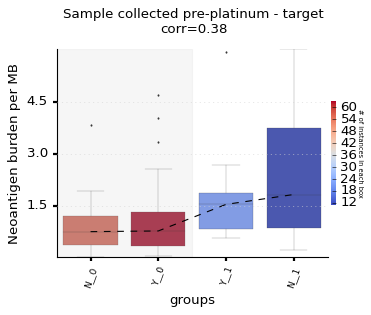

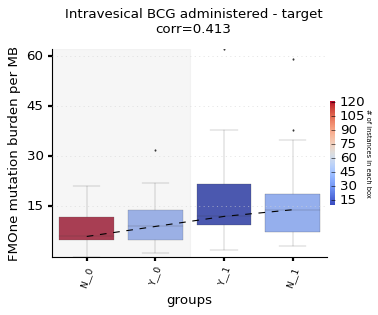

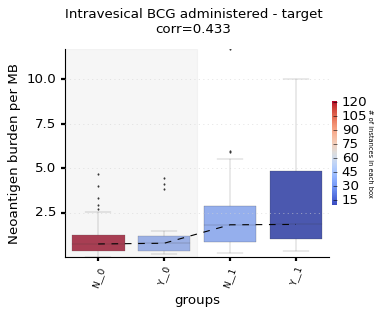

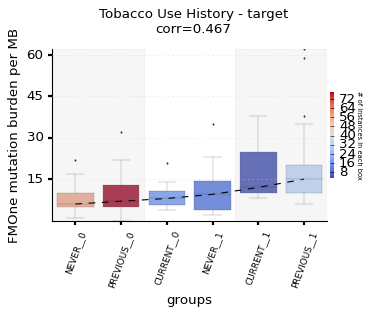

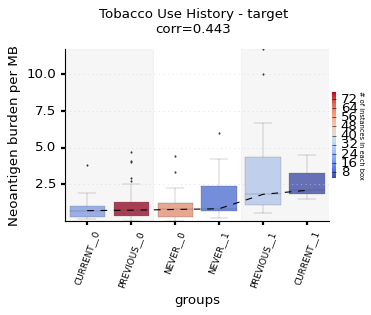

In [24]:
from src.utils.helper_boxplot import colored_boxplots

# set parameters for boxlot,
bt_dct = dict(figsize=(5,4), order=True, 
        cmap="coolwarm", patch_width=2, max_x_labels=None, labelsize=12)

# create boxplot for each categorical variable + tagret variable
for cat_fname in VAR_GROUPS["CATEGORICAL_VAR"]:
    for num_fname in VAR_GROUPS["QUANTITATIVE_VAR"]:
        colored_boxplots(
            df=data_df,
            yvar=num_fname, 
            xvars=[cat_fname, VAR_GROUPS["TARGET_VAR"][0]],
            bt_dct = bt_dct
        )

### check if some of covariants may have the same, or similar class distribusion as in the target variable
* for this purpose I am using function that I created in feb. 2020 that allows calulating columns with duplicated infromation
* the metrix returned is modified jaccard distance, that informas how much the two groups have mixed class labels
* it doen not depends on type of data in each variable, or the class content, but only on how well you can predict classes in one feature, using the class labels from another feature.
* similarity index (si) intepretaiton:
    * si = 1 - two features, are "colinear", ie knowning class label in one feature, we can always predict class labels in the second feature
    * si = 0.5 - class labels in two features are all mixed with each other, eg: having 2 class labels in each feature, they create all 4 possibilities, 
    * si < 0.5 - larger number of classes, creates more combinaitons between two features, 
* caution
    * si >05, may be generated when one feature, has smaller number of classes, then the second one, or it has more missing data
    * si ->1, may be generated when on feature has only one-two class labels, 
    * thus, always chek the table, with feature examples, 

__PERSONAL NOTE:__ i created this tool, its not perfect, but it helps identyfying most obvious duplicates, such as mean name in different languages, in dataframes with large number of columns,  

In [28]:
from src.utils.DataFrameExplorer import DataFrameExplorer_duplicates as dfe_dupl

In [29]:
# my function automatically selects text data, thus we must chnage dtype of the target variable to allow using it.
data_df.loc[:,"target"] = data_df.loc[:,"target"].astype('object')

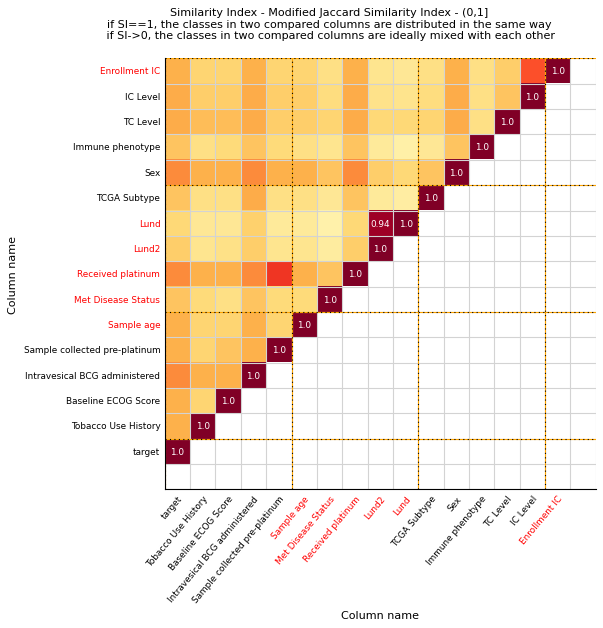

In [30]:
# plot similarity index and show table with the most similar columns
columns_summary, _, top_values_perc = dfe.summarize_df(df=data_df)

# calulate similarity index
cv_results = dfe_dupl.calculate_si(
    df=data_df, 
    df_ex=columns_summary, 
    groups_to_display="text",
    df_row_perc=100, # % of examples used for calulating si, 
    verbose=False
)

#plot pari-wise si results as custom heatmap, 
dfe_dupl.si_heatmap(df=cv_results, fig_size=(10,8), title_fontsize=10, axes_fontsize=8)

#### show pairs of features, with the most similar distribution of class labels, 

In [31]:
res_df = dfe_dupl.order_si_table(df_summary=columns_summary, df_cv_results=cv_results, SI_threshold=0.5, display_table=False)
res_df

attribute 1                    attribute 2  \
0                           Lund                          Lund2   
1              Received platinum  Sample collected pre-platinum   
2                  Enrollment IC                       IC Level   
3                            Sex              Received platinum   
4                            Sex  Intravesical BCG administered   
5                            Sex                         target   
6              Received platinum  Intravesical BCG administered   
7              Received platinum                         target   
8  Intravesical BCG administered                         target   

   similarity index                               examples attribute 1  \
0          0.936508  8    ('26.5%', 'MS2b1');('25.0%', 'MS1b');('19...   
1          0.683333  10    ('77.0%', 'Y');('23.0%', 'N')
Name: exam...   
2          0.623810  2    ('36.5%', 'IC1');('33.5%', 'IC2');('30.0%...   
3          0.500000  6    ('78.0%', 'M');('22.0%', 'F')
Name: examp...   
4          0.500000  6    ('78.0%', 'M');('22.0%', 'F')
Name: examp...   
5          0.500000  6    ('78.0%', 'M');('22.0%', 'F')
Name: examp...   
6          0.500000  10    ('77.0%', 'Y');('23.0%', 'N')
Name: exam...   
7          0.500000  10    ('77.0%', 'Y');('23.0%', 'N')
Name: exam...   
8          0.500000  14    ('78.5%', 'N');('21.5%', 'Y')
Name: exam...   

                                examples attribute 2  
0  9    ('32.5%', 'UroA');('26.5%', 'Infiltrated'...  
1  13    ('55.0%', 'Y');('45.0%', 'N')
Name: exam...  
2  3    ('36.7%', 'IC1');('33.7%', 'IC2+');('29.6...  
3  10    ('77.0%', 'Y');('23.0%', 'N')
Name: exam...  
4  14    ('78.5%', 'N');('21.5%', 'Y')
Name: exam...  
5  17    ('77.0%', 0);('23.0%', 1)
Name: examples...  
6  14    ('78.5%', 'N');('21.5%', 'Y')
Name: exam...  
7  17    ('77.0%', 0);('23.0%', 1)
Name: examples...  
8  17    ('77.0%', 0);('23.0%', 1)
Name: examples...